# Problem: Forecasting Stock Prices using Time Series Modeling
After the Gamestop fiasco with the subredit Wallstreetbets, I became very interested in doing a project with the stock market. The purpose of this project is to see if I can forecast stock prices using time-series modeling
## Method: ARIMA
## Data: Stock market prices from TDAmeritrade API
## Libraries:
- numpy
- pandas
- statsmodels
- requests
- plotly

## Import Libraries
We will be working with numpy, pandas, plotly, requests, and datetime

In [1]:
# Libraries for handling data
from information import client_id
import requests
import numpy as np
import pandas as pd
from datetime import datetime

# For visualizations
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# For time series modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

## Get our data using TDAmeritrade API

In [2]:
def get_data(symbol,
             client_id,
             periodType = 'year',
             n_periods = 20,
             frequencyType = 'daily',
             frequency = 1):
    """
    Yields a dataframe of  close price data for the given parameters
    
    --Parameters--
    
    symbol: Ticker symbol
    
    periodType: The type of period to show. Valid values are day, month, year, or ytd (year to date). Default is            day.
        
    n_periods: 	The number of periods to show.

        Example: For a 2 day / 1 min chart, the values would be:

        period: 2
        periodType: day
        frequency: 1
        frequencyType: min

        Valid periods by periodType (defaults marked with an asterisk):

        day: 1, 2, 3, 4, 5, 10*
        month: 1*, 2, 3, 6
        year: 1*, 2, 3, 5, 10, 15, 20
        ytd: 1*

    frequencyType: The type of frequency with which a new candle is formed. Valid frequencyTypes by periodType              (defaults marked with an asterisk):

        day: minute*
        month: daily, weekly*
        year: daily, weekly, monthly*
        ytd: daily, weekly*
    
    frequency: The number of the frequencyType to be included in each candle.

        Valid frequencies by frequencyType (defaults marked with an asterisk):

        minute: 1*, 5, 10, 15, 30
        daily: 1*
        weekly: 1*
        monthly: 1*
    
    """  
    # Initialize parameters
    parameters = {
        'apikey': client_id,
        'periodType': periodType,
        'period': str(n_periods),
        'frequencyType': frequencyType,
        'frequency': str(frequency),
    }
    
    # Request from API
    api_url = f'https://api.tdameritrade.com/v1/marketdata/{symbol}/pricehistory'
    data = requests.get(url = api_url, params = parameters).json()
    
    # Create dataframe
    dataframe = pd.DataFrame(data['candles'])

    # Convert to datetime format
    for i in range(len(dataframe['datetime'])):
        dataframe['datetime'][i] = datetime.fromtimestamp(dataframe['datetime'][i]/1000)
    
    # Set datetime to be our index
    dataframe = dataframe.set_index('datetime')

    # Remove open, high, low, and volumn columns.
    # For this project, we will be working only with the close price
    dataframe.drop(labels=[
                            'open',
                            'high',
                            'low',
                            'volume'
                            ], axis=1,
                            inplace=True
                    )
    
    return dataframe, symbol

In [3]:
SYMBOL = 'TSLA'
dataframe, symbol = get_data(symbol=SYMBOL,
                     client_id=client_id,
                     periodType = 'year',
                     n_periods = 20,
                     frequencyType = 'daily',
                     frequency = 1)

dataframe

<ipython-input-2-633b6772e4e4>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['datetime'][i] = datetime.fromtimestamp(dataframe['datetime'][i]/1000)


,close
datetime,
2001-08-05 22:00:00,120.30
2001-08-06 22:00:00,120.77
2001-08-07 22:00:00,118.53
2001-08-08 22:00:00,118.88
2001-08-09 22:00:00,119.29
...,...
2021-08-01 22:00:00,437.59
2021-08-02 22:00:00,441.15
2021-08-03 22:00:00,438.98


#### Let's check for NaN values

In [4]:

dataframe[dataframe.isna().any(axis=1)]

# If NaN value exist, use dataframe.dropna() to remove those rows
# dataframe.dropna(inplace=True)

,close
datetime,


#### High-level look at the dataframe

In [5]:
# Check out the details of the dataframe

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2001-08-05 22:00:00 to 2021-08-05 22:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   5033 non-null   float64
dtypes: float64(1)
memory usage: 78.6 KB


## Plot the Data

In [6]:
fig = go.Figure(data=go.Line(x=dataframe.index, y=dataframe['close']))
fig.update_layout(title=f'{symbol}',
                   xaxis_title='Year',
                   yaxis_title='Close Price')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(


## Calculate Returns

In [7]:
def calc_return(dataframe, lag=1):
    """
    Adds a column of the previous close to the dataframe.
    """
    prevClose = [x for x in dataframe['close'][:-lag]]
    prevClose = [np.nan for i in range(lag)] + prevClose
    dataframe[f'{lag}-day prevClose'] = prevClose
    dataframe['return'] = np.log(dataframe['close'] / dataframe[f'{lag}-day prevClose']).shift(1)
    
    return dataframe

In [8]:
calc_return(dataframe, lag=1).head(10)

,close,1-day prevClose,return
datetime,,,
2001-08-05 22:00:00,120.30,NaN,NaN
2001-08-06 22:00:00,120.77,120.30,NaN
2001-08-07 22:00:00,118.53,120.77,0.003899
2001-08-08 22:00:00,118.88,118.53,-0.018722
2001-08-09 22:00:00,119.29,118.88,0.002948
2001-08-12 22:00:00,119.32,119.29,0.003443
2001-08-13 22:00:00,119.27,119.32,0.000251
2001-08-14 22:00:00,118.24,119.27,-0.000419
2001-08-15 22:00:00,118.65,118.24,-0.008673


#### Plot Returns

In [9]:
fig = go.Figure(data=go.Line(x=dataframe.index, y=dataframe['return']))
fig.update_layout(title=f'{symbol} Returns',
                  xaxis_title='Year',
                  yaxis_title='Return')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# Test for stationarity: Dickey-Fuller Test
Stationarity implies the mean and standard deviation of the returns have no correlation with time. This is important because it allows for stability and some level of certainty in forecasting model

#### Calculate Rolling Mean and Standard Deviation

In [10]:
def mean_std(dataframe, length=20):
    """
    Adds 2 columns to our dataframe: A rolling mean and standard deviations of user-defined lengths
    """
    dataframe[f'sma{length}'] = dataframe['return'].rolling(length).mean()
    dataframe[f'std{length}'] = dataframe['return'].rolling(length).std()
    # Remove leading NaNs
    dataframe.dropna(inplace=True)

In [11]:
mean_std(dataframe)


In [12]:
dataframe

,close,1-day prevClose,return,sma20,std20
datetime,,,,,
2001-09-04 22:00:00,113.70,113.42,-0.006416,-0.002945,0.010971
2001-09-05 22:00:00,110.77,113.70,0.002466,-0.003016,0.010928
2001-09-06 22:00:00,108.72,110.77,-0.026107,-0.003386,0.011592
2001-09-09 22:00:00,110.05,108.72,-0.018680,-0.004467,0.011972
2001-09-16 22:00:00,104.30,110.05,0.012159,-0.004031,0.012425
...,...,...,...,...,...
2021-08-01 22:00:00,437.59,438.51,-0.004868,0.000930,0.007263
2021-08-02 22:00:00,441.15,437.59,-0.002100,0.000444,0.007116
2021-08-03 22:00:00,438.98,441.15,0.008103,0.000940,0.007294


In [13]:
fig = go.Figure()
fig.add_trace(go.Line(x=dataframe.index, y=dataframe['return'], name='Returns',
                         line=dict(color='blue', width=1)))
fig.add_trace(go.Line(x=dataframe.index, y=dataframe.iloc[:,3], name = dataframe.columns[3],
                         line=dict(color='red', width=1)))
fig.add_trace(go.Line(x=dataframe.index, y=dataframe.iloc[:,4], name=dataframe.columns[4],
                         line=dict(color='black', width=1)
))

fig.update_layout(title=f'{symbol}',
                   xaxis_title='Year')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### Perform Dickey-Fuller Test

In [14]:
dftest = sm.tsa.adfuller(dataframe['return'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic               -1.725603e+01
p-value                       5.982079e-30
#Lags Used                    1.700000e+01
Number of Observation Used    4.994000e+03
Critical Value (1%)          -3.431660e+00
Critical Value (5%)          -2.862119e+00
Critical Value (10%)         -2.567078e+00
dtype: float64

With a p-value < 0.05, we can reject the null hypothesis that there is a unit root. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

#### ACF

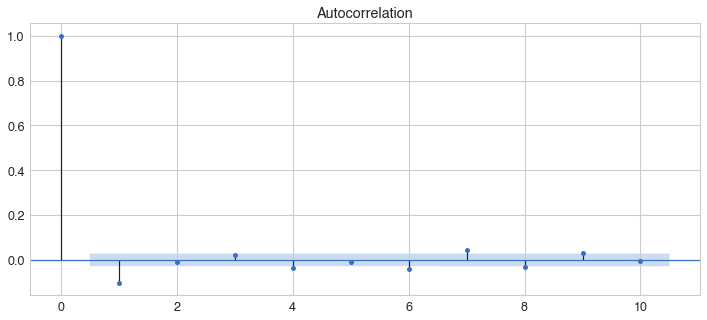

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(dataframe['return'], lags=10, ax=ax)
plt.show()

#### PACF

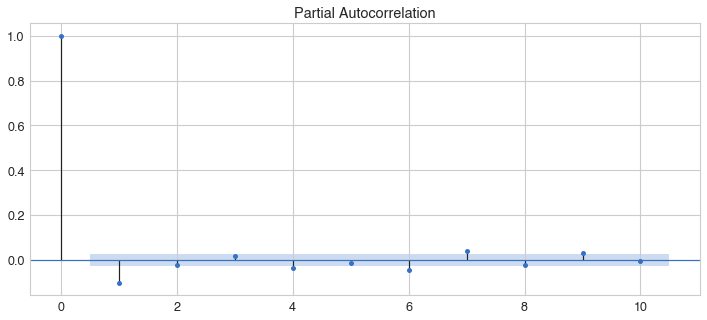

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(dataframe['return'], lags=10, ax=ax)
plt.show()

The above charts show the ACF and PACF readings give us a lag "p" of 6 and a lag "q" of 6

## Build ARIMA Model

In [17]:
ar1 = ARMA(tuple(dataframe['return']), (1,1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5012
Model:                     ARMA(1, 1)   Log Likelihood               14957.528
Method:                       css-mle   S.D. of innovations              0.012
Date:                Mon, 09 Aug 2021   AIC                         -29907.056
Time:                        12:22:28   BIC                         -29880.977
Sample:                             0   HQIC                        -29897.917
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.761      0.078   -3.06e-05       0.001
ar.L1.y        0.0739      0.136      0.544      0.586      -0.192       0.340
ma.L1.y       -0.1783      0.134     -1.330      0.184      -0.441       0.084
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           13.5350           +0.0000j           13.5350            0.0000
MA.1            5.6097           +0.0000j            5.6097            0.0000
-----------------------------------------------------------------------------
"""

In [18]:
preds = ar1.fittedvalues

#### Plot Predictions (Returns)

In [19]:
WINDOW_LENGTH = 400

fig = go.Figure()
fig.add_trace(go.Line(x=dataframe.index[-WINDOW_LENGTH:], y=dataframe['return'][-WINDOW_LENGTH:], name='Returns',
                         line=dict(color='blue', width=1)))
fig.add_trace(go.Line(x=dataframe.index[-WINDOW_LENGTH:], y=preds[-WINDOW_LENGTH:], name = 'Predictions',
                         line=dict(color='red', width=1)
))

fig.update_layout(title='Predictions vs Actual Returns',
                   xaxis_title='Year')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### Plot Predictions (Close Price)

In [20]:
dataframe['predictions'] = dataframe[dataframe.columns[1]] * (1 + preds)
dataframe

,close,1-day prevClose,return,sma20,std20,predictions
datetime,,,,,,
2001-09-04 22:00:00,113.70,113.42,-0.006416,-0.002945,0.010971,113.450628
2001-09-05 22:00:00,110.77,113.70,0.002466,-0.003016,0.010928,113.808581
2001-09-06 22:00:00,108.72,110.77,-0.026107,-0.003386,0.011592,110.788062
2001-09-09 22:00:00,110.05,108.72,-0.018680,-0.004467,0.011972,109.046615
2001-09-16 22:00:00,104.30,110.05,0.012159,-0.004031,0.012425,110.351036
...,...,...,...,...,...,...
2021-08-01 22:00:00,437.59,438.51,-0.004868,0.000930,0.007263,438.462868
2021-08-02 22:00:00,441.15,437.59,-0.002100,0.000444,0.007116,437.913414
2021-08-03 22:00:00,438.98,441.15,0.008103,0.000940,0.007294,441.415158


In [21]:
# Plot last WINDOW_LENGTH days for visibility
WINDOW_LENGTH = 400

fig = go.Figure()
fig.add_trace(go.Line(x=dataframe.index[-WINDOW_LENGTH:], y=dataframe['close'][-WINDOW_LENGTH:], name='Close Price',
                         line=dict(color='blue', width=1)))
fig.add_trace(go.Line(x=dataframe.index[-WINDOW_LENGTH:], y=dataframe['predictions'][-WINDOW_LENGTH:], name = 'Predictions',
                         line=dict(color='red', width=1)
))

fig.update_layout(title='Predictions vs Actual Returns',
                   xaxis_title='Year')
fig.show()

/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Forecast

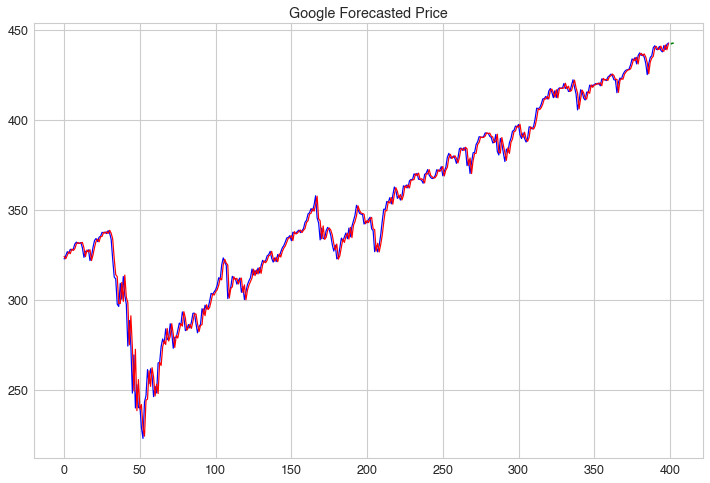

In [22]:
# Define number of steps to take
WINDOW_LENGTH = 200
steps = 2

# Define forecast array for 2 days into the future
forecast = ar1.forecast(steps=steps)[0]
forecast1 = dataframe['close'][-1] * (1 + forecast[0])
forecast2 = forecast1 * (1 + forecast[1])
forecast_array = np.array([forecast1, forecast2])

# Plot close price
plt.figure(figsize=(12, 8))
plt.plot(dataframe['close'][-WINDOW_LENGTH:].values, color='blue')

# Plot predicted close price
preds1=dataframe['predictions'][-WINDOW_LENGTH:].values
plt.plot(preds1, color='red')

# Plot forecasts
plt.plot(
    pd.DataFrame(
        np.array(
            [
                preds1[-1], forecast1
            ]
        ).T,
        index = range(
            len(
                dataframe['close'][-WINDOW_LENGTH:].values
            ) + 1,
            len(
                dataframe['close'][-WINDOW_LENGTH:].values
            ) + 3
        )
    ), color='green'
)

plt.plot(
    pd.DataFrame(
        forecast_array,
        index = range(
            len(
                dataframe['close'][-WINDOW_LENGTH:].values
            ) + 1,
            len(
                dataframe['close'][-WINDOW_LENGTH:].values
            ) + 1 + steps
        )
    ), color = 'green'
)

plt.title(f"{SYMBOL}'s Forecasted Price")
plt.show()

## Residuals

In [23]:
residuals = abs(dataframe['predictions'] - dataframe['close'])

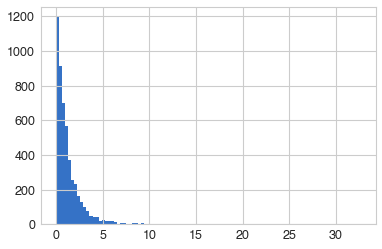

In [24]:
plt.hist(residuals.values, bins=100)
plt.show();

In [25]:
print("Mean Absolute Error: %.3f" % np.mean(residuals))
print("Standard Deviation: %.3f" % np.std(residuals))
print("AIC: %.3f" % ar1.aic)
print("Max error: %.3f" % np.max(residuals))

# Calc accuracy
direction_actual = np.where(dataframe['return'] > 0, 1, np.where(dataframe['return'] < 0, -1, 0))
direction_pred = np.where(preds > 0, 1, np.where(preds < 0, -1, 0))

dataframe['direction_actual'] = direction_actual
dataframe['direction_pred'] = direction_pred

total_obs = len(dataframe)
total_correct = sum([1 if dataframe['direction_actual'][i] == dataframe['direction_pred'][i] else 0 for i in range(len(dataframe))])
total_inc = sum([1 if dataframe['direction_actual'][i] != dataframe['direction_pred'][i] else 0 for i in range(len(dataframe))])

accuracy = (total_correct / total_obs) * 100
print("Accuracy: %.2f" % accuracy, "%")

Mean Absolute Error: 1.301
Standard Deviation: 1.714
AIC: -29907.056
Max residual: 32.598
Accuracy: 52.45 %


# Conclusion

In [26]:
print(f"The AIC of our mode is small at {round(ar1.aic, 3)}. But does this equate to a good model? Probably not.")
print(f"If we check the errors (predictions - close price), the mean absolute error is approximately {round(np.mean(residuals), 3)}, which may lead to some losses.")
print(f"At one point the model prediction was off by {round(np.max(residuals), 3)}, these trades would have resulted in enormous losses. ")

The AIC of our mode is small at -29907.056. But does this equate to a good model? Probably not.
If we check the errors (predictions - close price), the mean absolute error is approximately 1.301, which may lead to some losses.
At one point the model prediction was off by 32.598, these trades would have resulted in enormous losses. 
